# load library and dataset

In [407]:
import numpy as np
import pandas as pd
import matplotlib as mptb
import matplotlib.pyplot as plt
import seaborn as sns
#import missingno as msno
import sqlite3
from collections import Counter
import re

import warnings
warnings.filterwarnings('ignore')

In [462]:
df_netflix = pd.read_csv('netflix_titles.csv')

In [463]:
df_netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8800 non-null   object
 9   duration      8807 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [464]:
# rename column name 
df_netflix.rename(mapper={'type':'category','listed_in':'genre'},axis=1,inplace=True)

# transform dataset (cleaning)

In [465]:
#checking for missing values
df_netflix.isna().sum()

show_id            0
category           0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             7
duration           0
genre              0
description        0
dtype: int64

## handling null values

> director (2634 missing values): Imputation: Fill with a placeholder such as "Unknown".
> cast (825 missing values): Similar to director, this is also categorical; Imputation: Fill with a placeholder such as "Unknown".
> country (831 missing values):Imputation: Fill with "Unknown" or "Not Available". or Advanced: If the country is correlated with other features (e.g., based on language or genre), you could consider filling with the most frequent country per genre or a similar approach.
> date_added (10 missing values): Since this is a small percentage of missing values,Imputation: Fill with the mode (most frequent date) or the median date.or Consider dropping these rows if date_added is critical to your analysis.
> rating (4 missing values):  Since this is a small percentage of missing values,Imputation: Fill with the mode (most frequent date) or the median date.or Consider dropping these rows if date_added is critical to your analysis.
> duration (3 missing values):  Since this is a small percentage of missing values,Imputation: Fill with the mode (most frequent date) or the median date.or Consider dropping these rows if date_added is critical to your analysis.

In [466]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 1. Combine 'description', 'genre', and 'title' into a single text feature
df_netflix['text_features'] = df_netflix['title'].fillna('') + ' ' + df_netflix['genre'].fillna('') + ' ' + df_netflix['description'].fillna('')

# 2. Vectorize the text features using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_netflix['text_features'])

# 3. Impute missing 'country' based on similarity
for idx, row in df_netflix[df_netflix['country'].isnull()].iterrows():
    # Calculate similarity scores between the current row and all rows with non-null 'country'
    similarity_scores = cosine_similarity(tfidf_matrix[idx], tfidf_matrix[df_netflix['country'].notnull()]).flatten()
    
    # Find the index of the most similar row with a known 'country'
    most_similar_idx = np.argmax(similarity_scores)
    
    # Assign the country of the most similar row to the missing entry
    df_netflix.at[idx, 'country'] = df_netflix[df_netflix['country'].notnull()].iloc[most_similar_idx]['country']

# Check if any null values remain
print(df_netflix['country'].isnull().sum())


0


In [467]:
# Fill missing values for 'director', 'cast', 'country' with 'Unknown'
df_netflix['director'].fillna('Unknown', inplace=True)
print(df_netflix['director'].isnull().sum())

df_netflix['cast'].fillna('Unknown', inplace=True)
print(df_netflix['cast'].isnull().sum())

# Fill missing values for 'date_added', 'rating', and 'duration' with the mode
df_netflix['date_added'].fillna(df_netflix['date_added'].mode()[0], inplace=True)
print(df_netflix['date_added'].isnull().sum())


0
0
0


In [468]:
# Impute 'date_added' using the mode within each 'release_year'
df_netflix['date_added'] = df_netflix.groupby('release_year')['date_added'].transform(lambda x: x.fillna(x.mode()[0]))
print(df_netflix['date_added'].isnull().sum())

# Impute 'rating' using the mode within each 'genre'
df_netflix['rating'] = df_netflix.groupby('genre')['rating'].transform(lambda x: x.fillna(x.mode()[0]))
print(df_netflix['rating'].isnull().sum())

# Impute 'duration' using the mode within each 'genre' and 'type'
#df_netflix['duration'] = df_netflix.groupby(['genre', 'category'])['duration'].transform(lambda x: x.fillna(x.mode()[0]))
#print(df_netflix['duration'].isnull().sum())


0
0


In [469]:
# Convert 'date_added' to datetime
df_netflix['date_added'] = pd.to_datetime(df_netflix['date_added'], format='mixed')

In [470]:
# Ensure 'release_year' is an integer
df_netflix['release_year'] = df_netflix['release_year'].astype(int)

In [471]:
df_netflix.head()

,show_id,category,title,director,cast,country,date_added,release_year,rating,duration,genre,description,text_features
0,s2852,Movie,Uncovered,Zuko Nodada,"Nqobile Khumalo, Robert Hobbs, S'Thandiwe Kgor...",South Africa,2020-03-03,2019,TV-MA,98 min,"Dramas, International Movies","To solve her sister's murder, a corporate prot...","Uncovered Dramas, International Movies To solv..."
1,s2774,Movie,Willy and the Guardians of the Lake: Tales fro...,Zsolt Pálfi,"Csongor Szalay, Anna Kubik, Sári Vida, András ...",Hungary,2020-03-27,2019,TV-Y,72 min,Children & Family Movies,"As winter approaches the lake, a common threat...",Willy and the Guardians of the Lake: Tales fro...
2,s4826,Movie,Lust Stories,"Zoya Akhtar, Karan Johar, Anurag Kashyap, Diba...","Vicky Kaushal, Bhumi Pednekar, Radhika Apte, N...",India,2018-06-15,2018,TV-MA,121 min,"Comedies, Dramas, International Movies","In the companion to 2013's ""Bombay Talkies,"" f...","Lust Stories Comedies, Dramas, International M..."
3,s3150,Movie,Zindagi Na Milegi Dobara,Zoya Akhtar,"Hrithik Roshan, Abhay Deol, Farhan Akhtar, Kat...",India,2019-12-15,2011,TV-14,154 min,"Comedies, Dramas, International Movies",Three friends on an adventurous road trip/bach...,"Zindagi Na Milegi Dobara Comedies, Dramas, Int..."
4,s3144,Movie,Luck by Chance,Zoya Akhtar,"Farhan Akhtar, Konkona Sen Sharma, Rishi Kapoo...",India,2019-12-15,2009,TV-14,156 min,"Dramas, International Movies, Romantic Movies",When Vikram gets tapped to play the male lead ...,"Luck by Chance Dramas, International Movies, R..."


## create columns & variables

In [472]:
movies = df_netflix[df_netflix['category'] == 'Movie']
tv_shows = df_netflix[df_netflix['category'] == 'TV Show']

In [473]:
# Add columns     
df_netflix['duration_minutes'] = df_netflix['duration'].str.extract('(\d+)').astype(float)
df_netflix['month_added'] = df_netflix['date_added'].dt.month
df_netflix['ymonth_added'] = df_netflix['date_added'].dt.to_period('M')
df_netflix['title_length'] = df_netflix['title'].apply(len).astype(int)
movies_duration = df_netflix[df_netflix['category'] == 'Movie']['duration_minutes']
tv_shows_seasons = df_netflix[df_netflix['category'] == 'TV Show']['duration_minutes']


# Exploratory Data Analysis (EDA)

In [474]:
print('The columns of the Netflix data frame are :-  ',df_netflix.columns)

The columns of the Netflix data frame are :-   Index(['show_id', 'category', 'title', 'director', 'cast', 'country',
       'date_added', 'release_year', 'rating', 'duration', 'genre',
       'description', 'text_features', 'duration_minutes', 'month_added',
       'ymonth_added', 'title_length'],
      dtype='object')


## 1. What is the distribution of Movies vs. TV Shows?

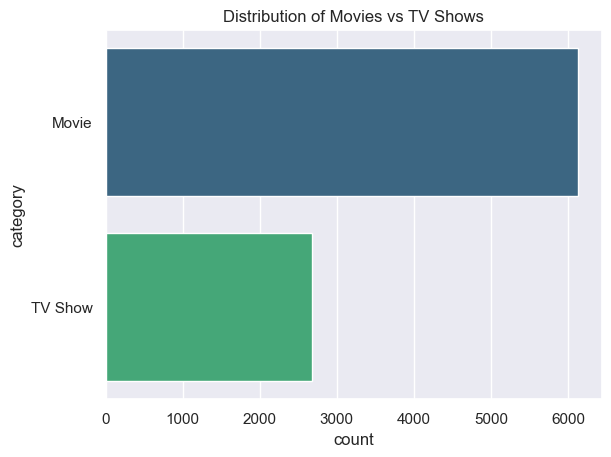

In [475]:
# How many movies are there compared to TV shows?
sns.countplot(y='category', data=df_netflix, palette="viridis")
plt.title('Distribution of Movies vs TV Shows')
plt.show()

It is evident that there are more Movies on Netflix than TV shows

## 2. What are the most common release years for content?

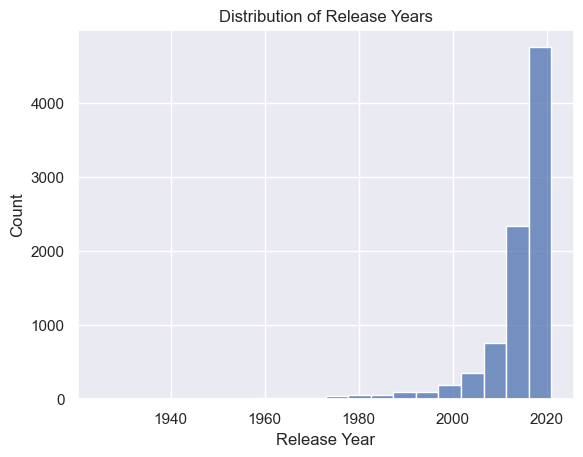

In [476]:
# In which years were most of the Netflix titles released?
sns.histplot(df_netflix['release_year'], bins=20, kde=False)
plt.title('Distribution of Release Years')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.show()

In [477]:
# Average Release Year by Content Type
average_release_year = df_netflix.groupby('category')['release_year'].mean()
print("Average Release Year by Content Type:")
average_release_year

Average Release Year by Content Type:


category
Movie      2013.121514
TV Show    2016.605755
Name: release_year, dtype: float64

## 3. Are there any trends in content addition over time?

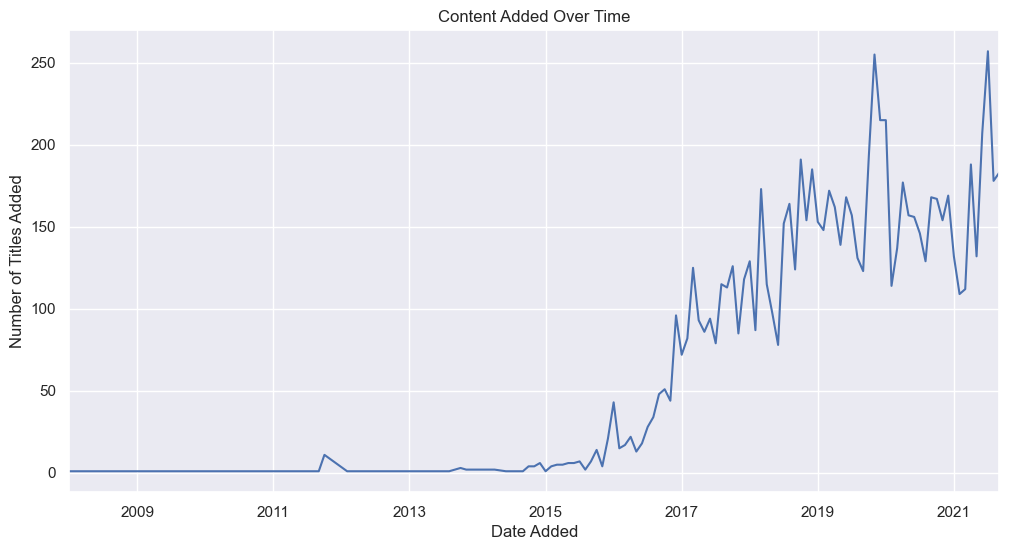

In [478]:
content_over_time = df_netflix.groupby('ymonth_added').size()

plt.figure(figsize=(12, 6))
content_over_time.plot()
plt.title('Content Added Over Time')
plt.xlabel('Date Added')
plt.ylabel('Number of Titles Added')
plt.show()


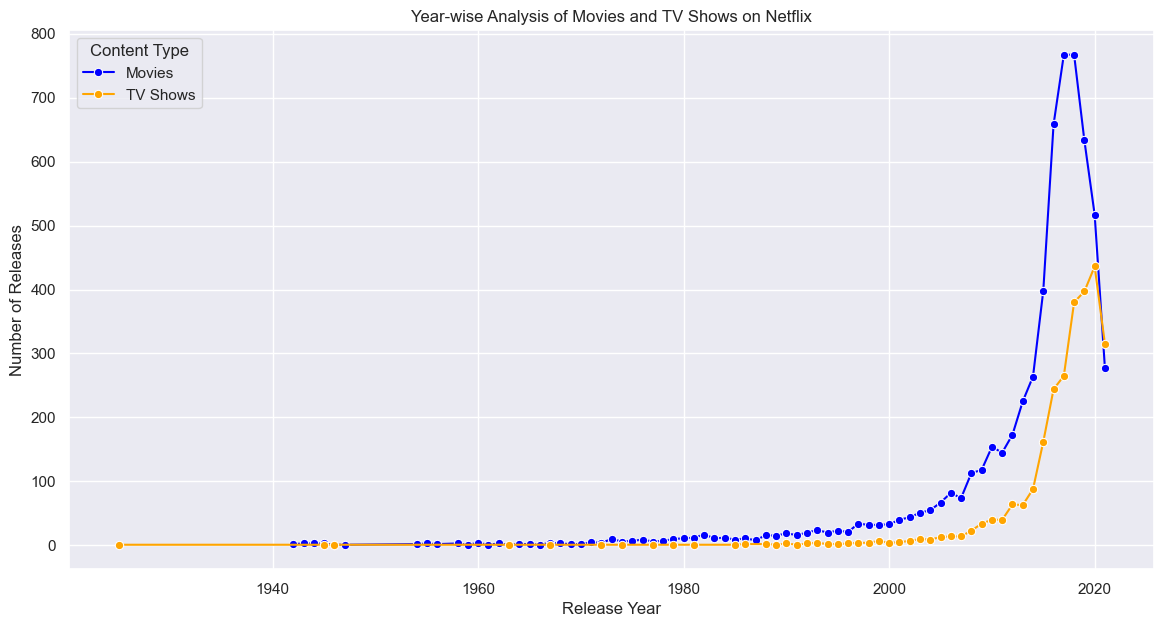

In [479]:
# Year wise analysis for contents
movies_per_year = movies.groupby('release_year').size()
tv_shows_per_year = tv_shows.groupby('release_year').size()

plt.figure(figsize=(14, 7))

sns.lineplot(x=movies_per_year.index, y=movies_per_year.values, marker='o', label='Movies', color='blue')
sns.lineplot(x=tv_shows_per_year.index, y=tv_shows_per_year.values, marker='o', label='TV Shows', color='orange')

plt.title('Year-wise Analysis of Movies and TV Shows on Netflix')
plt.xlabel('Release Year')
plt.ylabel('Number of Releases')
plt.grid(True)
plt.legend(title='Content Type')
plt.show()


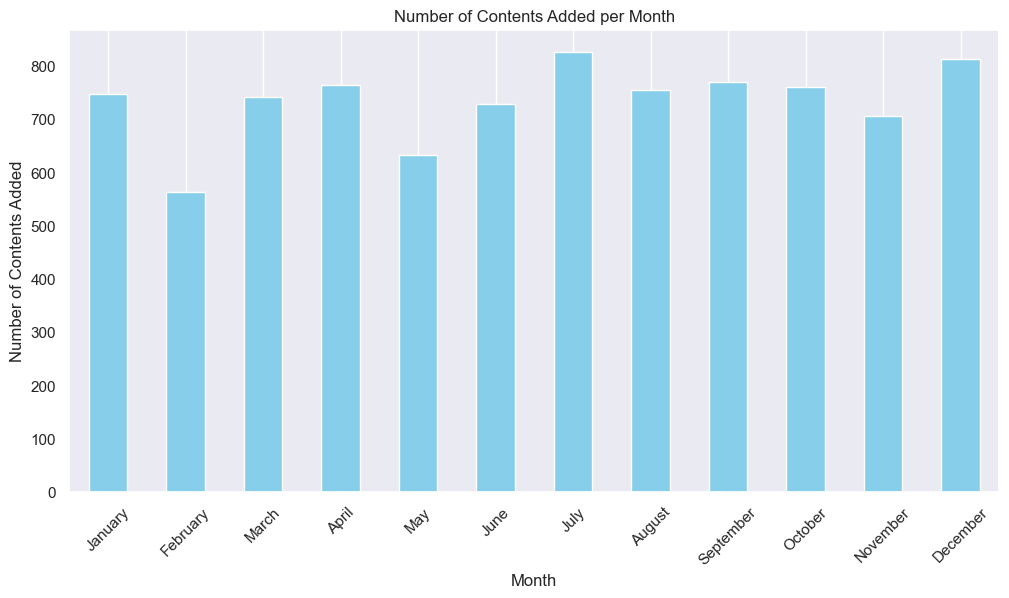

In [480]:
# Determining the Optimal Month for Content Release
month_counts = df_netflix['month_added'].value_counts().sort_index()

# 4. Map month numbers to month names
month_names = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
month_labels = [month_names[i - 1] for i in month_counts.index]

plt.figure(figsize=(12, 6))
month_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Contents Added per Month')
plt.xlabel('Month')
plt.ylabel('Number of Contents Added')
plt.xticks(ticks=range(len(month_counts.index)), labels=month_labels, rotation=45)
plt.grid(axis='y')
plt.show()


In [481]:
# Find the month with the least/optimal amount of content added
least_month = month_counts.idxmin()
least_month_name = month_names[least_month - 1]
least_month_count = month_counts.min()

optimal_month = month_counts.idxmax()
optimal_month_name = month_names[optimal_month - 1]
optimal_month_count = month_counts.max()

print(f'The month with the least amount of content added is {least_month_name} with {least_month_count} entries.')
print(f'The month with the optimal amount of content added is {optimal_month_name} with {optimal_month_count} entries.')

The month with the least amount of content added is February with 563 entries.
The month with the optimal amount of content added is July with 827 entries.


## 4. Which countries produce the most content?

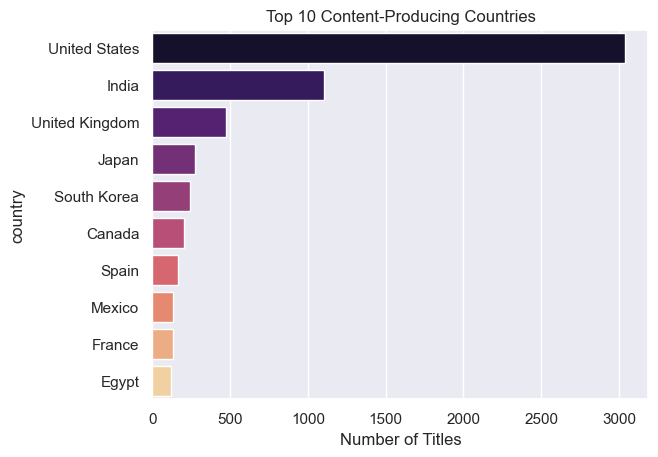

In [482]:
# Which countries contribute the most content to Netflix?
top_countries = df_netflix['country'].value_counts().head(10)
sns.barplot(x=top_countries, y=top_countries.index, palette="magma")
plt.title('Top 10 Content-Producing Countries')
plt.xlabel('Number of Titles')
plt.show()


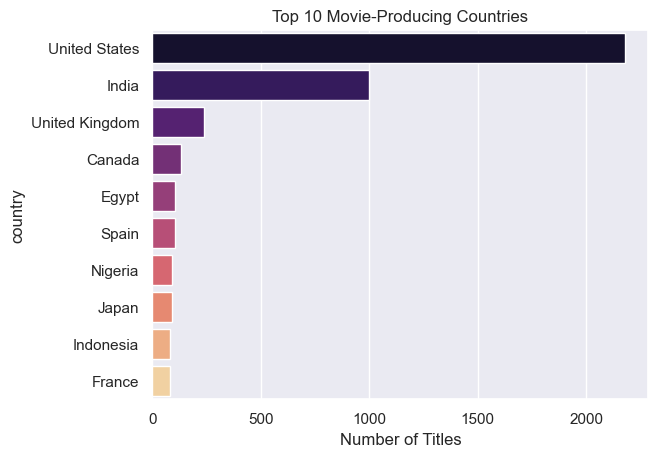

In [483]:
top_countries_movies = movies['country'].value_counts().head(10)
sns.barplot(x=top_countries_movies, y=top_countries_movies.index, palette="magma")
plt.title('Top 10 Movie-Producing Countries')
plt.xlabel('Number of Titles')
plt.show()

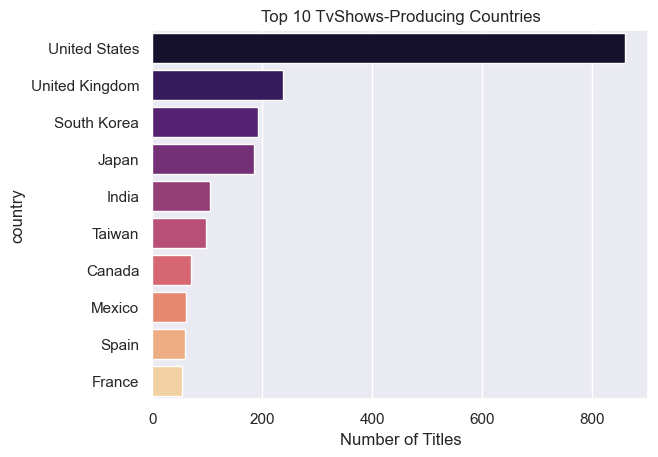

In [484]:
top_countries_shows = tv_shows['country'].value_counts().head(10)
sns.barplot(x=top_countries_shows, y=top_countries_shows.index, palette="magma")
plt.title('Top 10 TvShows-Producing Countries')
plt.xlabel('Number of Titles')
plt.show()

## 5. Movie ratings analysis

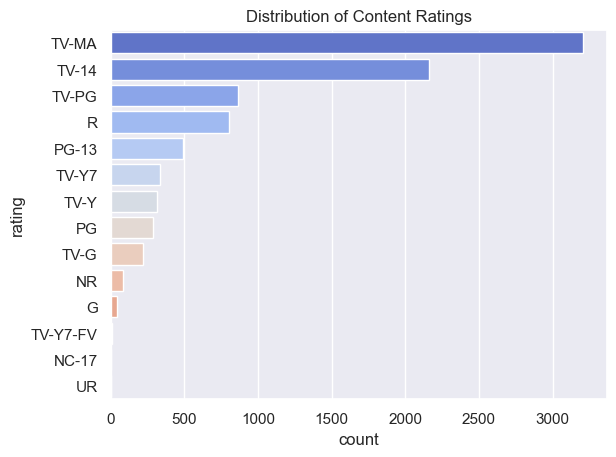

In [485]:
# Which ratings (like PG, R, TV-MA) are most common in the dataset?
sns.countplot(y='rating', data=df_netflix, palette="coolwarm", order=df_netflix['rating'].value_counts().index)
plt.title('Distribution of Content Ratings')
plt.show()


In [486]:
# Analysing IMDB ratings to get top rated movies on Netflix


## 6. How does the duration of movies differ from TV shows?

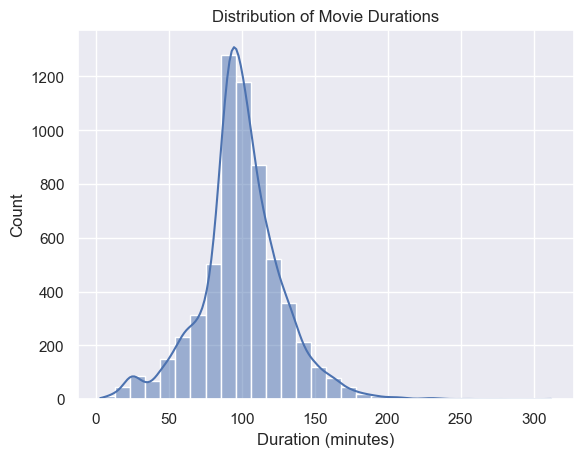

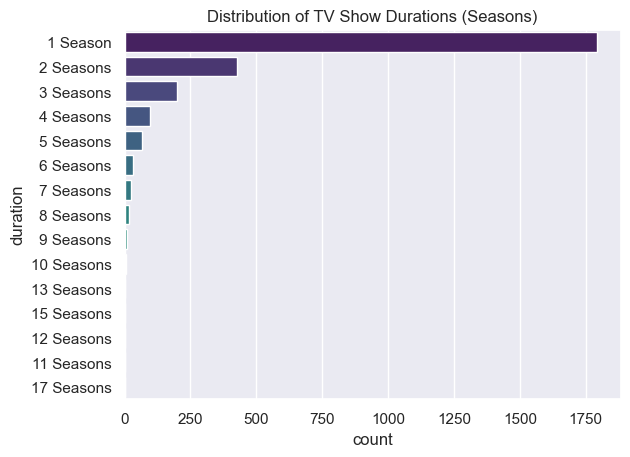

In [487]:
# What is the distribution of durations for movies and TV shows?
sns.histplot(movies_duration, bins=30, kde=True)
plt.title('Distribution of Movie Durations')
plt.xlabel('Duration (minutes)')
plt.show()

sns.countplot(y=tv_shows['duration'], order=tv_shows['duration'].value_counts().index, palette="viridis")
plt.title('Distribution of TV Show Durations (Seasons)')
plt.show()

So, a good amount of movies on Netflix are among the duration of 75-120 mins. It is acceptable considering the fact that a fair amount of the audience cannot watch a 3 hour movie in one sitting. Can you? :p

In [488]:
# Longest & Shortest Content Duration
max_movie_duration = movies_duration.max()
min_movie_duration = movies_duration.min()
max_tv_show_seasons = tv_shows_seasons.max()

longest_movie = df_netflix[(df_netflix['category'] == 'Movie') & (df_netflix['duration_minutes'] == max_movie_duration)]
longest_tv_show = df_netflix[(df_netflix['category'] == 'TV Show') & (df_netflix['duration_minutes'] == max_tv_show_seasons)]
shortest_movie = df_netflix[(df_netflix['category'] == 'Movie') & (df_netflix['duration_minutes'] == min_movie_duration)]

print("Longest & Shortest Content Duration")
longest_content = pd.concat([longest_movie, longest_tv_show,shortest_movie])
longest_content[['title', 'category', 'duration', 'release_year','genre', 'country']]

Longest & Shortest Content Duration


,title,category,duration,release_year,genre,country
7974,Black Mirror: Bandersnatch,Movie,312 min,2018,"Dramas, International Movies, Sci-Fi & Fantasy",United States
7999,Grey's Anatomy,TV Show,17 Seasons,2020,"Romantic TV Shows, TV Dramas",United States
2968,Silent,Movie,3 min,2014,"Children & Family Movies, Sci-Fi & Fantasy",United States


In [489]:
# Longest movie title
top_10_longest_titles = df_netflix[df_netflix['category'] == 'Movie'].sort_values(by='title_length', ascending=False).head(10)

longest_movie_titles_df = top_10_longest_titles[['title','genre', 'release_year', 'duration','country']]
longest_movie_titles_df

,title,genre,release_year,duration,country
5140,Jim & Andy: The Great Beyond - Featuring a Ver...,Documentaries,2017,94 min,"Canada, United States"
1545,The Power of Grayskull: The Definitive History...,Documentaries,2017,96 min,"Canada, United States"
7743,Mike Birbiglia: What I Should Have Said Was No...,Stand-Up Comedy,2008,56 min,United States
2726,Steve Martin and Martin Short: An Evening You ...,Stand-Up Comedy,2018,74 min,United States
2808,Cultivating the Seas: History and Future of th...,"Documentaries, International Movies",2019,45 min,Japan
8162,"Power Rangers Samurai: Christmas Together, Fri...",Movies,2011,24 min,United States
1,Willy and the Guardians of the Lake: Tales fro...,Children & Family Movies,2019,72 min,Hungary
8626,Ya no estoy aquí: Una conversación entre Guill...,Documentaries,2020,15 min,Mexico
8223,The Road to El Camino: Behind the Scenes of El...,"Documentaries, International Movies",2019,14 min,United States
6141,Green White Green (And All the Beautiful Colou...,"Comedies, Independent Movies, International Mo...",2016,102 min,Nigeria


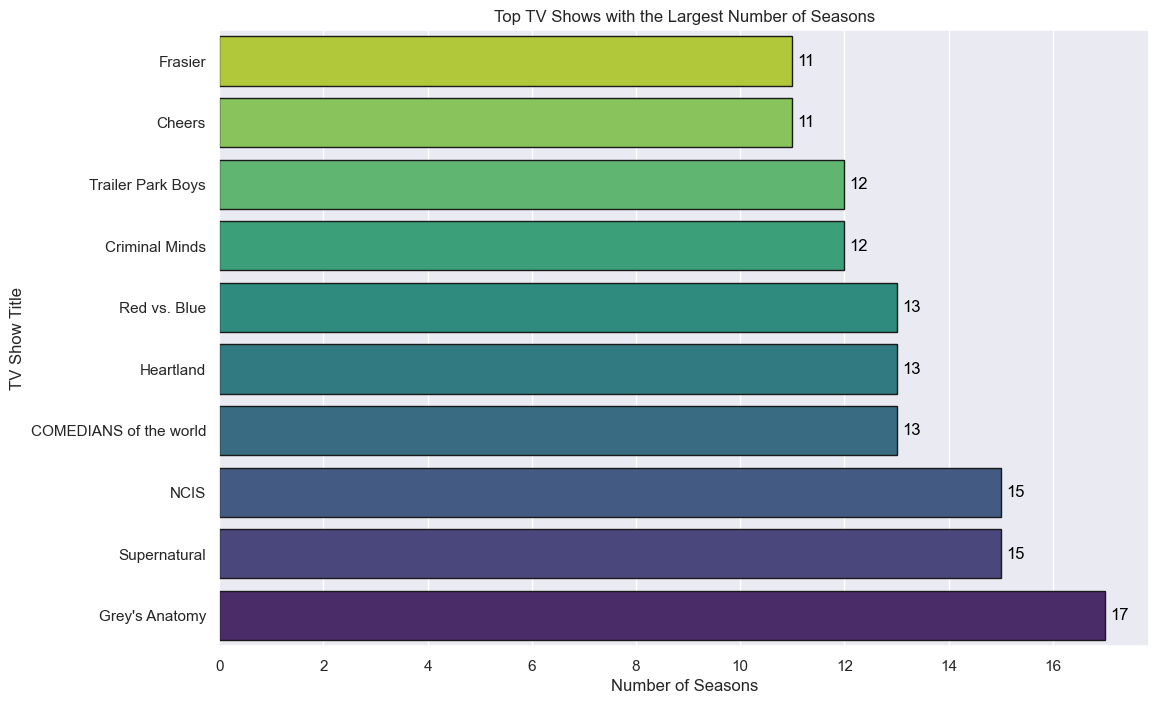

In [490]:
#TV shows with largest number of seasons
tv_shows['number_of_seasons'] = tv_shows['duration'].str.extract('(\d+)').astype(float)
tv_shows_sorted = tv_shows.sort_values(by='number_of_seasons', ascending=False)
top_tv_shows = tv_shows_sorted[['title', 'number_of_seasons']].head(10)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_tv_shows,  y='title',  x='number_of_seasons',  palette='viridis',  edgecolor='k')
# Add data labels to each bar
for index, value in enumerate(top_tv_shows['number_of_seasons']):
    plt.text(value + 0.1, index, str(int(value)), va='center', color='black')
plt.xlabel('Number of Seasons')
plt.ylabel('TV Show Title')
plt.title('Top TV Shows with the Largest Number of Seasons')
plt.gca().invert_yaxis()  # Highest number of seasons at the top
plt.show()


## 7. What are the most popular genres?

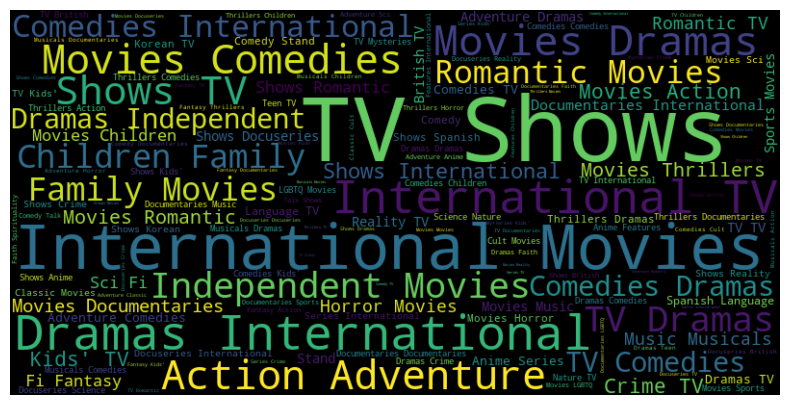

In [491]:
# WordCloud for Genres. !pip install wordcloud matplotlib
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# 'plasma', 'magma', 'inferno'
genre_text = ' '.join(df_netflix['genre'].dropna().astype(str))

# 2. Generate the WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='viridis').generate(genre_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axes for the WordCloud
plt.show()

## 7. Who are the most mentioned genres/directors / actors/ casts on Netflix?

## functions

In [493]:
# Function to clean and split cast names
def clean_names(series):
    # Combine all cast entries into one string
    combined = ' '.join(series.dropna().astype(str))
    # Remove unwanted characters (preserve names with spaces)
    cleaned = re.sub(r'[^\w\s,]', '', combined)  # Remove special characters except commas and spaces
    # Split names on commas and strip extra spaces
    names = [name.strip() for name in cleaned.split(',')]
    return names

In [504]:
def generate_wordcloud(df, column_name, title,pallette):
    """
    Generate and display a WordCloud for the names in a specified column of a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_name (str): The column name to process (e.g., 'cast' or 'director').
    title (str): The title for the WordCloud.
    """
    # Clean names and prepare text for WordCloud
    names_list = clean_names(df[column_name])
    text = ' '.join(names_list)  # Join all names into a single string

    # Generate the WordCloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color=pallette, 
        colormap='viridis',
        max_words=200,  # Adjust as needed
        min_font_size=10  # Adjust as needed
    ).generate(text)

    # Display the WordCloud
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide the axes
    plt.title(title)
    plt.show()

In [500]:
def plot_top_10(df, column_name, title):
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame")

    # Clean names and count occurrences
    names_list = clean_names(df[column_name])
    name_counts = Counter(names_list)
    top_10_names = name_counts.most_common(10)

    # Convert to DataFrame for easier plotting
    top_10_df = pd.DataFrame(top_10_names, columns=['Name', 'Count'])
    top_10_df = top_10_df.set_index('Name')  # Set the 'Name' column as index

    # Plot the top 10 names using seaborn
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x=top_10_df['Count'], y=top_10_df.index, palette="cubehelix")

    # Add data labels to each bar
    for container in ax.containers:
        # Iterate over the bars
        for bar in container:
            width = bar.get_width()
            ax.text(width + 0.1, bar.get_y() + bar.get_height() / 2, 
                    f'{int(width)}', 
                    ha='left', va='center')

    plt.title(title)
    plt.xlabel('Number of Mentions')
    plt.show()

## plots

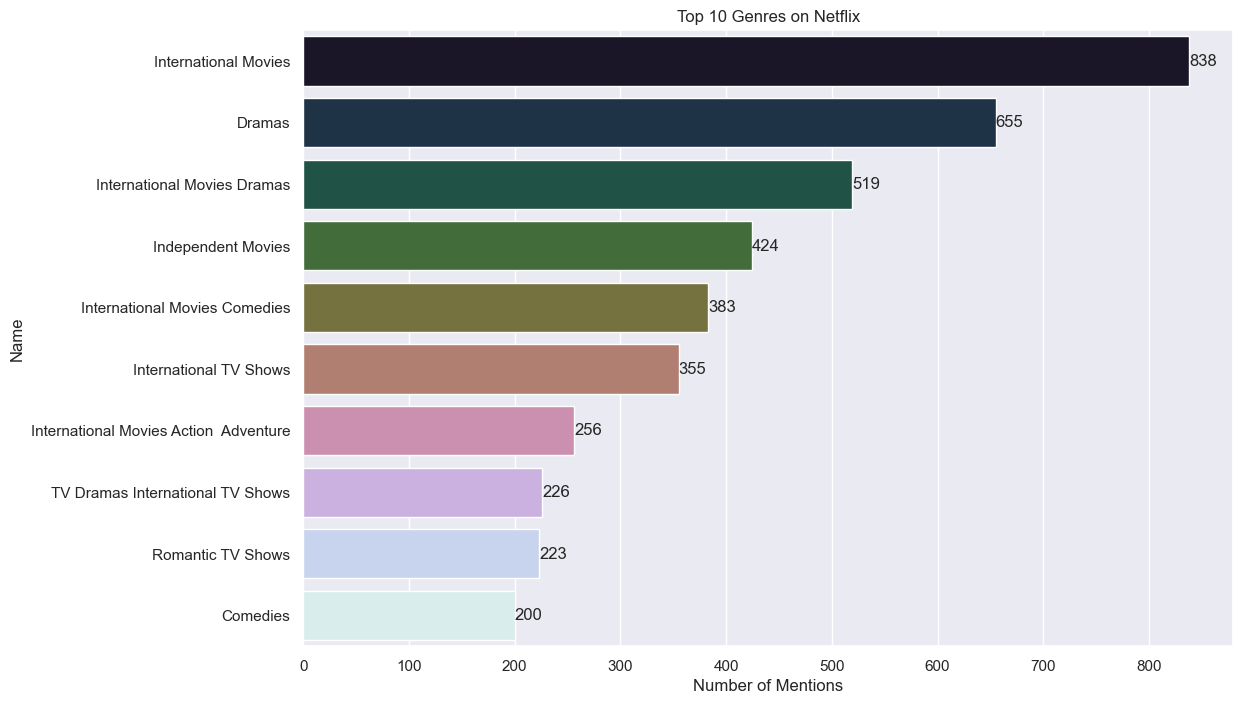

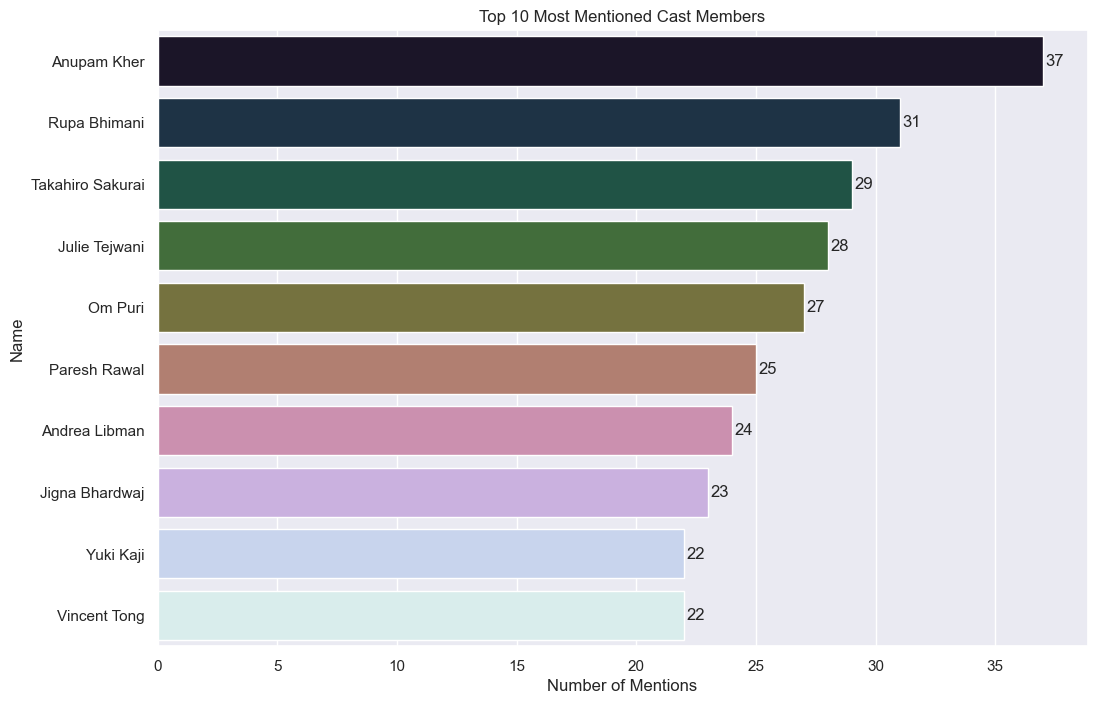

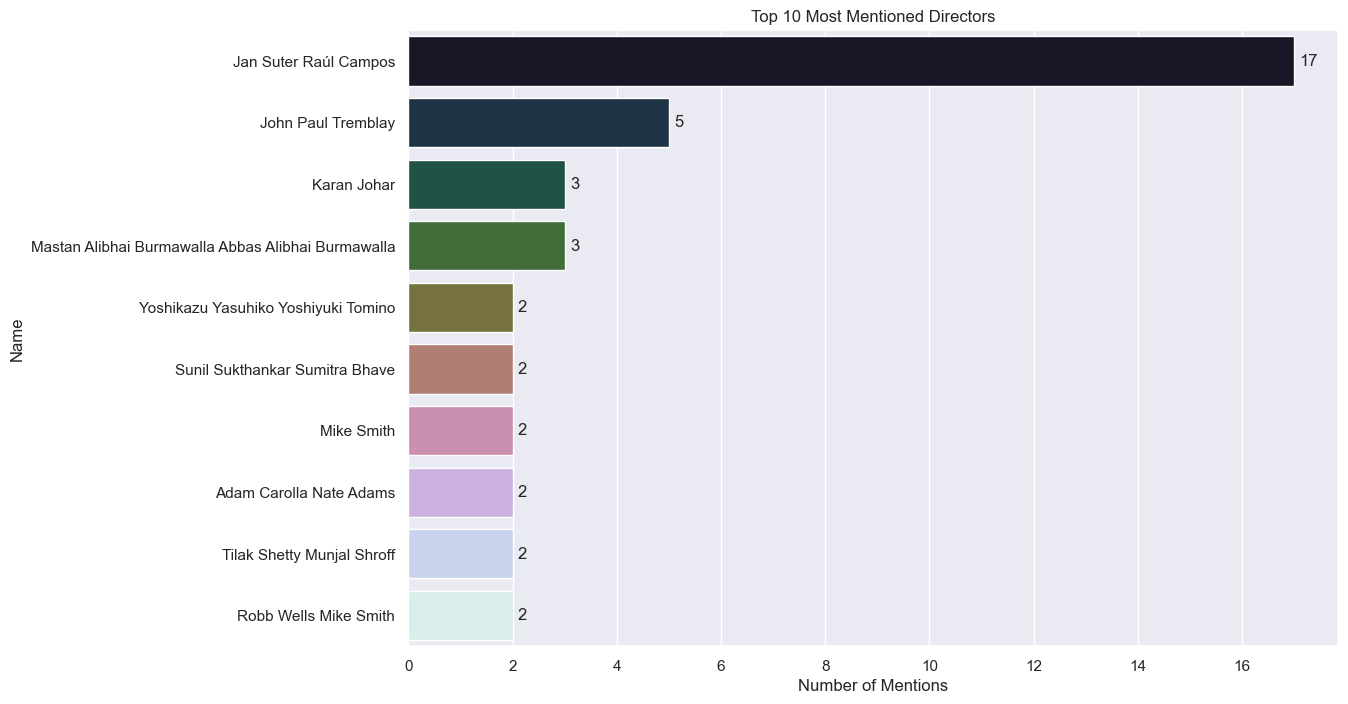

In [501]:
# Plot top 10 genres
plot_top_10(df_netflix, 'genre', 'Top 10 Genres on Netflix')

# Plot top 10 cast members
plot_top_10(df_netflix, 'cast', 'Top 10 Most Mentioned Cast Members')

# Plot top 10 directors
plot_top_10(df_netflix, 'director', 'Top 10 Most Mentioned Directors')

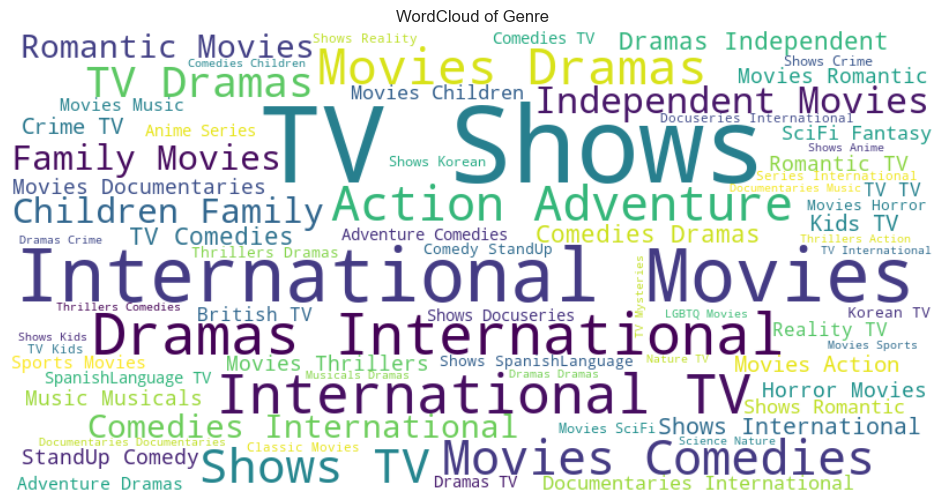

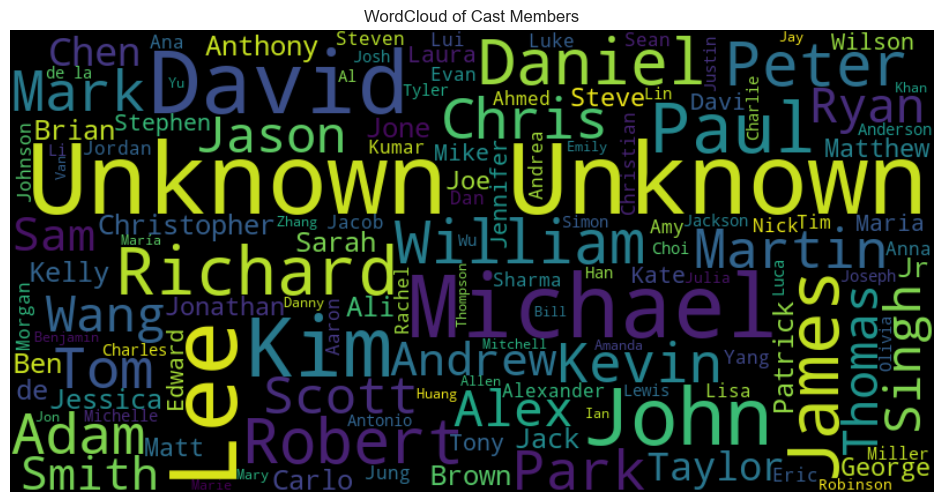

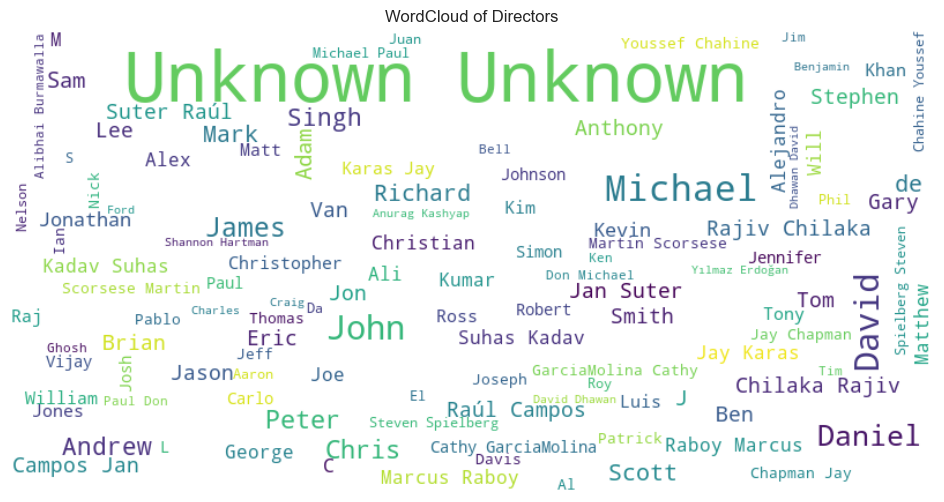

In [505]:
# Generate and display WordCloud for genre 
generate_wordcloud(df_netflix, 'genre', 'WordCloud of Genre','white')

# Generate and display WordCloud for cast members
generate_wordcloud(df_netflix, 'cast', 'WordCloud of Cast Members','black')

# Generate and display WordCloud for directors
generate_wordcloud(df_netflix, 'director', 'WordCloud of Directors','white')

## 8. How does the content vary by country and genre?

### function

In [511]:
def expand_values(df, country_col, genre_col):
    """
    Expand rows where the country and genre columns have multiple values separated by commas.

    Parameters:
    df (pd.DataFrame): DataFrame containing title, country, and genre columns.
    country_col (str): The column name containing country information.
    genre_col (str): The column name containing genre information.

    Returns:
    pd.DataFrame: Expanded DataFrame with separate rows for each country-genre combination.
    """
    # Split the country and genre columns into lists and explode them into separate rows
    df_expanded = df.assign(**{country_col: df[country_col].str.split(','),
                               genre_col: df[genre_col].str.split(',')}).explode(country_col).explode(genre_col)
    
    # Clean up any leading/trailing whitespace
    df_expanded[country_col] = df_expanded[country_col].str.strip()
    df_expanded[genre_col] = df_expanded[genre_col].str.strip()
    
    return df_expanded

In [512]:
def plot_genre_prevalence(df, country_col, genre_col):
    """
    Plot the prevalence of genres by country using a heatmap.

    Parameters:
    df (pd.DataFrame): DataFrame containing country and genre columns.
    country_col (str): The column name containing country information.
    genre_col (str): The column name containing genre information.
    """
    # Expand the DataFrame to handle multiple values
    df_expanded = expand_values(df, country_col, genre_col)
    
    # Group by country and genre, then count occurrences
    genre_country_counts = df_expanded.groupby([country_col, genre_col]).size().reset_index(name='count')
    
    # Pivot the table for heatmap
    genre_country_pivot = genre_country_counts.pivot(index=country_col, columns=genre_col, values='count').fillna(0)
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(genre_country_pivot, cmap='YlGnBu', annot=True, fmt='.0f')  # Use '.0f' for integer format
    plt.title('Prevalence of Genres by Country')
    plt.xlabel('Genre')
    plt.ylabel('Country')
    plt.show()


### plot

In [521]:
df_exp = expand_values(df_netflix, 'country', 'genre')

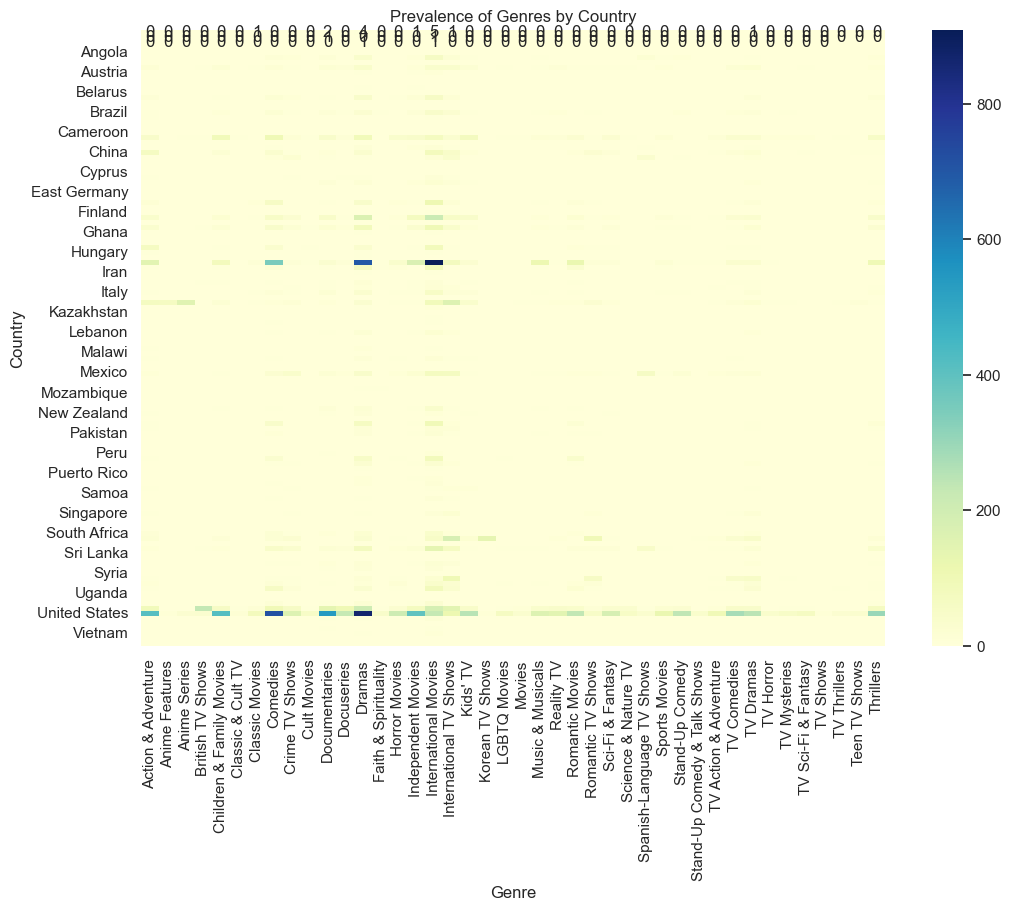

In [522]:
plot_genre_prevalence(df_netflix, 'country', 'genre')

### 9 Content in the UK

In [523]:
# Add 'number_of_seasons' column
df_netflix['number_of_seasons'] = df_netflix['duration'].astype(str).apply(extract_seasons)

# Filter for UK content
uk_content = df_netflix[df_netflix['country'].str.contains('United Kingdom', na=False)]

# Split the UK content into movies and TV series
uk_movies = uk_content[uk_content['category'] == 'Movie']
uk_series = uk_content[uk_content['category'] == 'TV Show']

# Find oldest and newest UK movies
oldest_uk_movie = uk_movies.loc[uk_movies['release_year'].idxmin()]
newest_uk_movie = uk_movies.loc[uk_movies['release_year'].idxmax()]

# Find oldest and newest UK TV series
oldest_uk_series = uk_series.loc[uk_series['release_year'].idxmin()]
newest_uk_series = uk_series.loc[uk_series['release_year'].idxmax()]

In [178]:
# Create DataFrames for each result with additional details
oldest_uk_movie_df = pd.DataFrame([{
    'Type': 'Oldest UK Movie',
    'Title': oldest_uk_movie['title'],
    'Release Year': oldest_uk_movie['release_year'],
    'Date Added': oldest_uk_movie['date_added'],
    'Duration': oldest_uk_movie['duration'],
    'Genre': oldest_uk_movie['genre'],
    'Director': oldest_uk_movie['director']
}])

newest_uk_movie_df = pd.DataFrame([{
    'Type': 'Newest UK Movie',
    'Title': newest_uk_movie['title'],
    'Release Year': newest_uk_movie['release_year'],
    'Date Added': newest_uk_movie['date_added'],
    'Duration': newest_uk_movie['duration'],
    'Genre': newest_uk_movie['genre'],
    'Director': newest_uk_movie['director']
}])

oldest_uk_series_df = pd.DataFrame([{
    'Type': 'Oldest UK TV Series',
    'Title': oldest_uk_series['title'],
    'Release Year': oldest_uk_series['release_year'],
    'Date Added': oldest_uk_series['date_added'],
    'Duration': oldest_uk_series['duration'],
    'Genre': oldest_uk_series['genre'],
    'Director': oldest_uk_series['director']
}])

newest_uk_series_df = pd.DataFrame([{
    'Type': 'Newest UK TV Series',
    'Title': newest_uk_series['title'],
    'Release Year': newest_uk_series['release_year'],
    'Date Added': newest_uk_series['date_added'],
    'Duration': newest_uk_series['duration'],
    'Genre': newest_uk_series['genre'],
    'Director': newest_uk_series['director']
}])


In [179]:
# Combine all into a single DataFrame
UK_content_df = pd.concat([
    oldest_uk_movie_df,
    newest_uk_movie_df,
    oldest_uk_series_df,
    newest_uk_series_df,
])

UK_content_df


,Type,Title,Release Year,Date Added,Duration,Genre,Director
0,Oldest UK Movie,Tunisian Victory,1944,2017-03-31,76 min,"Classic Movies, Documentaries","Frank Capra, John Huston, Hugh Stewart, Roy Bo..."
0,Newest UK Movie,Final Account,2021,2021-09-02,94 min,Documentaries,Luke Holland
0,Oldest UK TV Series,Monty Python's Fliegender Zirkus,1972,2018-10-02,1 Season,"International TV Shows, TV Comedies",Unknown
0,Newest UK TV Series,The Great British Baking Show,2021,2021-09-24,9 Seasons,"British TV Shows, Reality TV",Andy Devonshire


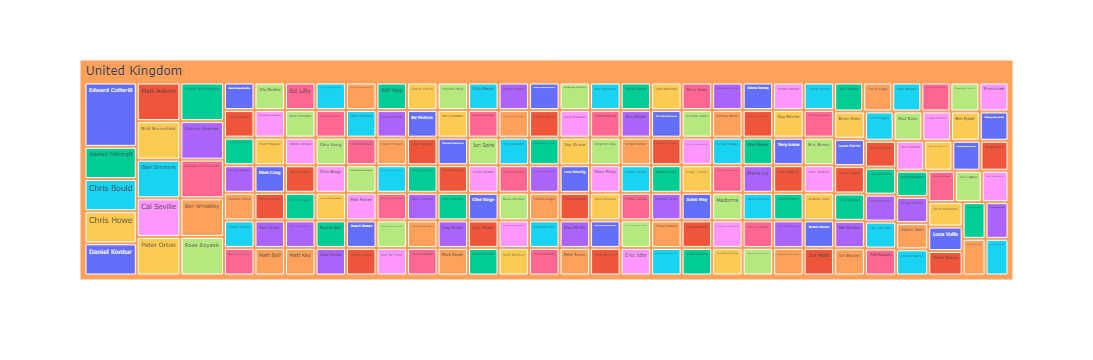

In [186]:
import plotly.express as px

netflix_uk = df_netflix[(df_netflix['country'] == 'United Kingdom') & (df_netflix['director'] != 'Unknown')]
#nannef=netflix_uk.dropna()

fig = px.treemap(netflix_uk, path=['country','director'],
                  color='director', hover_data=['title', 'genre','release_year','duration'],
                 color_continuous_scale='Purples')
fig.show()

# Recommendation System (Content Based)

# SQL Analysis

In [ ]:
# import sqlalchemy and create a sqlite engine
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)

# export the dataframe as a table 'playstore' to the sqlite engine
df_netflix.to_sql("netflix", con =engine)